# Deep Learning: common issues and solutions

In [1]:
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

In [2]:
def myplot(history):
    params = ["accuracy", "loss"]
    fig, axs = plt.subplots(1, len(params), figsize=(15, 5))

    for pos, e in enumerate(params):
      # summarize history for accuracy
      axs[pos].plot(history.history[f'{e}'])
      axs[pos].plot(history.history[f'val_{e}'])
      axs[pos].set_title(f'model {e}')
      axs[pos].set_ylabel(f'{e}')
      axs[pos].set_xlabel('epoch')
      axs[pos].legend(['train', 'val'], loc='upper left')

    plt.show()

In [3]:
def evaluate_the_model(model, X_test_encoded, y_test):
    y_pred_encoded = model.predict(X_test_encoded)
    y_pred = np.argmax(y_pred_encoded, axis=1) + 1

    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred, normalize='true'), annot=True)

## 1. Today lab

In this lab, we are going to look at various architecture of recurrent neural network and how to use them with the Keras API.
Note that this lab will be graded and will count towards you're TD grade. 

In [4]:
add_notebook_menu()

# Dataset pre-processing

In this lab, we will just re-use the dataset of previous lab providing Sentiment Analysis tasks. 
However, since we're using RNNs, we will work with sequence data therefore the preprocessing is a bit different than the previous lab.

In [5]:
import pandas as pd
import numpy as np
import nltk
import pylab as pl # package inheriting most of matplotlib package functions with shorter syntax 
import seaborn as sns

nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

### a) Essential reminder [About Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [6]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


### b) Build X (features vectors) and y (labels)

In [7]:
# Construct X_train and y_train
X_train = TRAIN['Reviews'].fillna("")
y_train = TRAIN['Rating']
X_train.shape, y_train.shape

((5000,), (5000,))

In [8]:
# Construct X_val and y_val
X_val = VAL['Reviews'].fillna("")
y_val = VAL['Rating']
X_val.shape, y_val.shape

((1000,), (1000,))

In [9]:
# Construct X_test and y_test
X_test = TEST['Reviews'].fillna("")
y_test = TEST['Rating']
X_test.shape, y_test.shape

((1000,), (1000,))

In [10]:
from sklearn.preprocessing import OneHotEncoder

In [11]:
ohe = OneHotEncoder(handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val_encoded = ohe.transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test_encoded = ohe.transform(np.array(y_test).reshape(-1, 1)).toarray()

# Define constant
n_classes = len(np.unique(y_train))

[ TO DO STUDENTS]

Use the following function to normalize your data. Each line corresponds to a normalization task, use the lines you find relevant and explain what they do.

In [12]:
''' Put your code here '''
import nltk
nltk.download('popular')
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import string

try:
    import emoji
except:
    !pip install emoji
    import emoji

# instantiation of the stemmer to make the stemming preprocessing on the input
stemmer = PorterStemmer().stem

def clean_text(text):
    # Concatenate a vector of words if the text is a vector
    text = ''.join(text)
    
    # Normalizing by puuting every word to lower case
    text = text.lower()
    
    # removing leading and trailing punctuation symbols
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # removing words containing digits
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # importing english stop words
    stop = stopwords.words('english')
    # cleaning from stop word
    text = [x for x in text if x not in stop]
    
    # keep only words of length bigger than 0
    text = [t for t in text if len(t) > 0]
    
    # stemming the text
    text = [stemmer(t) for t in text]
    
    # keep only words on length bigger than 2
    text = [t for t in text if len(t) > 2]
    
    return " ".join(text)

''' After this stage '''
# X_train_norm contain normalized text for X_train
# X_val_norm contain normalized text for X_val
# X_test_norm contain normalized text for X_test
X_train_norm = [clean_text(r) for r in X_train]
X_val_norm = [clean_text(r) for r in X_val]
X_test_norm = [clean_text(r) for r in X_test]


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

[ TO DO STUDENTS]

Explain the role of tokenization and each argument of the fit_on_texts method

-- We use tokenization in order to split the text into tokens that will be next used in the learning phase.

In [13]:
# Get the vocabulary size
from nltk.tokenize import word_tokenize
# nltk.download('punkt') # If nltk requires to download 'punkt' depending on your installation
reviews_tokenized = [word_tokenize(review) for review in X_train]
# Count the vocabulary
flatten_reviews = [item for sublist in reviews_tokenized for item in sublist] # contain all words 
unique_words = list(set(flatten_reviews)) #processed as a list for future analysis
vocabulary_size = len(unique_words) # set allows to get unique words contain in flatten_reviews
vocabulary_size

13099

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

VOCABULARY_SIZE = vocabulary_size
FILTERS='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'

# create the tokenizer

# instantiation of the tokenizer. Num of words is the cardinality of the set of 
# word of our text. The text will be filtered in order to remove punctuation 
# symbols. The lower = True, put the text in lower case. 
# split = ' ' -> The text is splitted into a list of word on the space character
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE,
              filters=FILTERS,
              lower=True,
              split=' ',
              oov_token="_UNK_")

# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)
print('Found %s unique tokens.' % len(tokenizer.word_index))

# encode documents
X_train_enc = tokenizer.texts_to_sequences(X_train_norm)
X_val_enc = tokenizer.texts_to_sequences(X_val_norm)
X_test_enc = tokenizer.texts_to_sequences(X_test_norm)

Found 9292 unique tokens.


[ TO DO STUDENTS]

We now need to pad our sequences. Explain what padding is and find a good value for the padding length by looking at the distribution of the sequence lengths.

We add padding to get vectors of same size. It is used for exaple to apply batch

(array([4.56e+03, 2.91e+02, 8.20e+01, 2.90e+01, 1.20e+01, 9.00e+00,
        7.00e+00, 4.00e+00, 3.00e+00, 3.00e+00]),
 array([  0. ,  51.2, 102.4, 153.6, 204.8, 256. , 307.2, 358.4, 409.6,
        460.8, 512. ]),
 <a list of 10 Patch objects>)

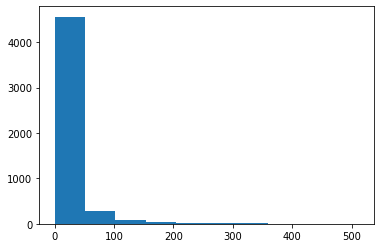

In [15]:
import matplotlib.pyplot as plt
sequence_sizes = list(map(len, X_train_enc))
plt.hist(sequence_sizes)

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# We can choose a length 200 for the padding since it is a length that: 
# 1. trunks those reviews that are too long, not giving a lot of useful
# informations. Long sentences also add a lot of sparsity in the matrix.
# 2. allows to keep the majority of reviews since they are within this bound.

max_words = 200     # Nombre de mots dans une review
padding_mode = 'pre'
padding_value = 0
truncating_mode='post'

X_train_enc2 = pad_sequences(X_train_enc,
                            maxlen=max_words,
                            padding=padding_mode,
                            truncating=truncating_mode,
                            value=padding_value)
X_val_enc2 = pad_sequences(X_val_enc,
                            maxlen=max_words,
                            padding=padding_mode,
                            truncating=truncating_mode,
                            value=padding_value)
X_test_enc2 = pad_sequences(X_test_enc,
                            maxlen=max_words,
                            padding=padding_mode,
                            truncating=truncating_mode,
                            value=padding_value)
X_train_enc2.shape

(5000, 200)

# Training RNN models

We will now train various architectures of RNN on our data and evaluate their performances. We will be testing five baseline architectures. For each of them, build a simple model, train it on the train data and evaluate its performance on the test data.

At the end of this section, you will be asked to present a comparative analysis of the models (in whatever way you want : a table, a plot, ...)

## Simple RNN



[ TO DO STUDENTS]

Briefly explain the role of the Embedding layer as well as the functionning the most basic RNN (Simple RNN layer).

Then build, train and predict a model with a simpleRNN layer. Don't forget to store the results for the comparative analysis

In [17]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
embedding_size=50
model1=Sequential()
# We embed the text in order to vectorize the words and get informations allowing
# us to know the similarity between two sentences looking at their vectors.
# For example, queen-woman vector will be similar to the king-man vector.
# Thanks to this similarity, we can make some operations to get for example
# "man" starting with queen-king+woman
# We can do a similar reasoning with capitals and country vectors and so on.
# In this case we perform the embedding in order to compare reviews and
# try to find similarities between them 
model1.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5

rnn = SimpleRNN(
    10,
    activation='tanh'
)

model1.add(rnn)

# Output
dense1 = Dense(units=nb_classes, activation="softmax")

model1.add(dense1)

print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           654950    
                                                                 
 simple_rnn (SimpleRNN)      (None, 10)                610       
                                                                 
 dense (Dense)               (None, 5)                 55        
                                                                 
Total params: 655,615
Trainable params: 655,615
Non-trainable params: 0
_________________________________________________________________
None


In [18]:
model1.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [19]:
batch_size = 64
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)

# fit model
history1 = model1.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
79/79 [==============================] - 20s 208ms/step - loss: 1.3551 - accuracy: 0.5078 - val_loss: 1.2430 - val_accuracy: 0.5550
Epoch 2/100
79/79 [==============================] - 13s 166ms/step - loss: 1.1988 - accuracy: 0.5470 - val_loss: 1.2015 - val_accuracy: 0.5670
Epoch 3/100
79/79 [==============================] - 13s 158ms/step - loss: 1.0764 - accuracy: 0.6060 - val_loss: 1.1601 - val_accuracy: 0.5990
Epoch 4/100
79/79 [==============================] - 14s 175ms/step - loss: 0.9475 - accuracy: 0.6862 - val_loss: 1.1203 - val_accuracy: 0.6190
Epoch 5/100
79/79 [==============================] - 13s 160ms/step - loss: 0.8365 - accuracy: 0.7358 - val_loss: 1.1028 - val_accuracy: 0.6240
Epoch 6/100
79/79 [==============================] - 15s 193ms/step - loss: 0.7821 - accuracy: 0.7710 - val_loss: 1.1387 - val_accuracy: 0.6070
Epoch 7/100
79/79 [==============================] - 13s 161ms/step - loss: 0.6840 - accuracy: 0.8076 - val_loss: 1.1599 - val_accuracy:

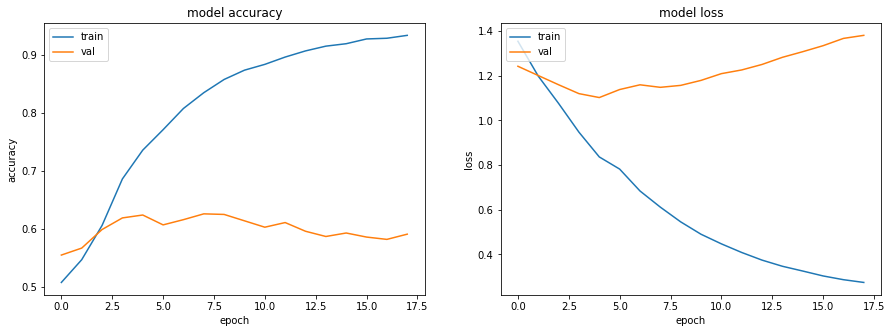

In [20]:
myplot(history1)

## GRU

[ TO DO STUDENTS]

Briefly explain the added benefit of a GRU model
Build, train and predict a model with a GRU layer.

GRU layer is a short-term Memory and it is a simplified version of the LSTM layer

In [21]:
embedding_size=50
model2=Sequential()
model2.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5

gru = GRU(
    10,
    activation='tanh'
)

model2.add(gru)

# Output
dense2 = Dense(units=nb_classes, activation="softmax")

model2.add(dense2)

print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 50)           654950    
                                                                 
 gru (GRU)                   (None, 10)                1860      
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 656,865
Trainable params: 656,865
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
model2.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [23]:
batch_size = 64
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)

# fit model
history2 = model2.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
79/79 [==============================] - 4s 17ms/step - loss: 1.4490 - accuracy: 0.5134 - val_loss: 1.2210 - val_accuracy: 0.5590
Epoch 2/100
79/79 [==============================] - 1s 11ms/step - loss: 1.1630 - accuracy: 0.5614 - val_loss: 1.1101 - val_accuracy: 0.5980
Epoch 3/100
79/79 [==============================] - 1s 10ms/step - loss: 1.0467 - accuracy: 0.6136 - val_loss: 1.0572 - val_accuracy: 0.6110
Epoch 4/100
79/79 [==============================] - 1s 10ms/step - loss: 0.9429 - accuracy: 0.6554 - val_loss: 1.0130 - val_accuracy: 0.6370
Epoch 5/100
79/79 [==============================] - 1s 10ms/step - loss: 0.8472 - accuracy: 0.6930 - val_loss: 1.0133 - val_accuracy: 0.6360
Epoch 6/100
79/79 [==============================] - 1s 10ms/step - loss: 0.7663 - accuracy: 0.7274 - val_loss: 1.0016 - val_accuracy: 0.6580
Epoch 7/100
79/79 [==============================] - 1s 10ms/step - loss: 0.7016 - accuracy: 0.7476 - val_loss: 1.0338 - val_accuracy: 0.6460
Epoch 

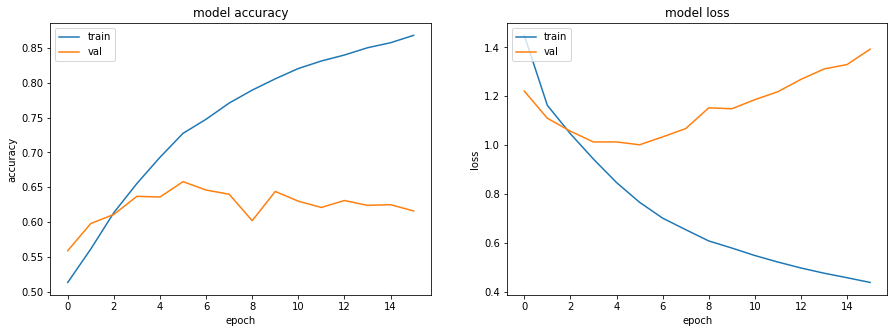

In [24]:
myplot(history2)

## LSTM
[ TO DO STUDENTS]

Briefly explain the added benefit of a LSTM model.
Build, train and predict a model with a LSTM layer.

LSTM layer is able to analyse not only one input at the time but, it has a "Long short-term" memory which tracks informations about the previous context. It is able to understand speech, machine translation and so on.

In [25]:
embedding_size=50
model3=Sequential()
model3.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5

lstm = LSTM(
    10,
    activation='tanh'
)

model3.add(lstm)

# Output
dense3 = Dense(units=nb_classes, activation="softmax")

model3.add(dense3)

print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 50)           654950    
                                                                 
 lstm (LSTM)                 (None, 10)                2440      
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 657,445
Trainable params: 657,445
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
model3.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [27]:
batch_size = 64
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)

# fit model
history3 = model3.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
79/79 [==============================] - 3s 23ms/step - loss: 1.3816 - accuracy: 0.5276 - val_loss: 1.2040 - val_accuracy: 0.5620
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 1.1582 - accuracy: 0.5760 - val_loss: 1.0787 - val_accuracy: 0.6140
Epoch 3/100
79/79 [==============================] - 1s 11ms/step - loss: 1.0099 - accuracy: 0.6476 - val_loss: 0.9986 - val_accuracy: 0.6450
Epoch 4/100
79/79 [==============================] - 1s 11ms/step - loss: 0.9106 - accuracy: 0.6746 - val_loss: 0.9736 - val_accuracy: 0.6550
Epoch 5/100
79/79 [==============================] - 1s 11ms/step - loss: 0.8414 - accuracy: 0.6870 - val_loss: 0.9717 - val_accuracy: 0.6590
Epoch 6/100
79/79 [==============================] - 1s 11ms/step - loss: 0.7936 - accuracy: 0.7018 - val_loss: 0.9891 - val_accuracy: 0.6510
Epoch 7/100
79/79 [==============================] - 1s 11ms/step - loss: 0.7530 - accuracy: 0.7138 - val_loss: 0.9843 - val_accuracy: 0.6590
Epoch 

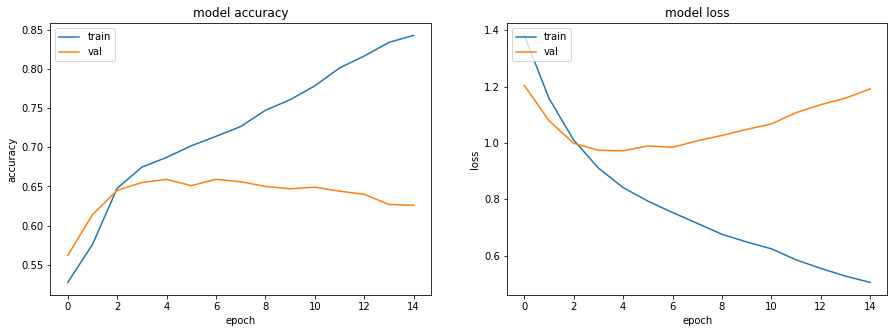

In [28]:
myplot(history3)

## Bidirectionnal LSTM 
[ TO DO STUDENTS]

Briefly explain what the Bidirectional layer adds compared to a nomal LSTM.
Build, train and predict a model with a LSTM layer.

Bidirectional LSTM layers reads not only input from left to right but also from right to left. It may be useful if for example to have more precise information for example for the sematic of tokens (subject, verb...) of the corpus.

In [29]:
from keras.layers import Bidirectional
embedding_size=50
model4=Sequential()
model4.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5

lstm = LSTM(
    10,
    activation='tanh'
)

bidir = Bidirectional(lstm)

model4.add(bidir)

# Output
dense4 = Dense(units=nb_classes, activation="softmax")

model4.add(dense4)

print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 50)           654950    
                                                                 
 bidirectional (Bidirectiona  (None, 20)               4880      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 5)                 105       
                                                                 
Total params: 659,935
Trainable params: 659,935
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
model4.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [31]:
batch_size = 64
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)

# fit model
history4 = model4.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
79/79 [==============================] - 5s 28ms/step - loss: 1.3507 - accuracy: 0.5362 - val_loss: 1.2046 - val_accuracy: 0.5590
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 1.1772 - accuracy: 0.5592 - val_loss: 1.1113 - val_accuracy: 0.6050
Epoch 3/100
79/79 [==============================] - 1s 18ms/step - loss: 1.0425 - accuracy: 0.6370 - val_loss: 1.0034 - val_accuracy: 0.6480
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 0.9241 - accuracy: 0.6728 - val_loss: 0.9727 - val_accuracy: 0.6650
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.8475 - accuracy: 0.6908 - val_loss: 0.9681 - val_accuracy: 0.6620
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.7800 - accuracy: 0.7118 - val_loss: 0.9755 - val_accuracy: 0.6680
Epoch 7/100
79/79 [==============================] - 1s 17ms/step - loss: 0.7319 - accuracy: 0.7374 - val_loss: 0.9847 - val_accuracy: 0.6540
Epoch 

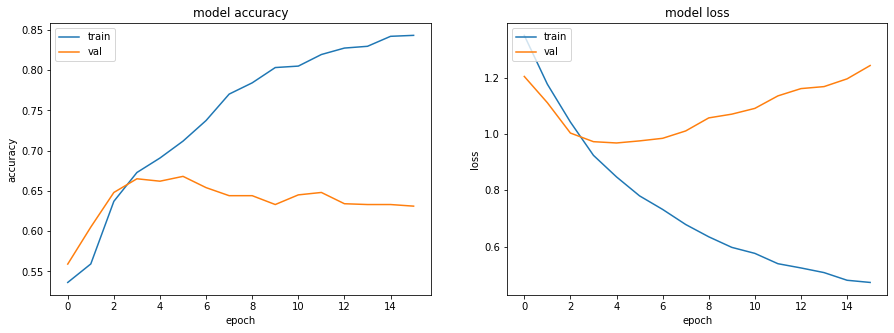

In [32]:
myplot(history4)

## Bidirectionnal LSTM with multiple layers

[ TO DO STUDENTS]

Build, train and predict a model with stacked LSTM layers.

In [33]:
model5=Sequential()
model5.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5
num_layer = 2

for i in range(num_layer):
  lstm = LSTM(
      10,
      activation='tanh',
      return_sequences=(i != num_layer - 1)
  )

  bidir = Bidirectional(lstm)

  model5.add(bidir)

# Output
dense5 = Dense(units=nb_classes, activation="softmax")

model5.add(dense5)

print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 50)           654950    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 20)          4880      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 20)               2480      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 105       
                                                                 
Total params: 662,415
Trainable params: 662,415
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
model5.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [35]:
batch_size = 64
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)

# fit model
history5 = model5.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
79/79 [==============================] - 9s 50ms/step - loss: 1.3212 - accuracy: 0.5298 - val_loss: 1.1933 - val_accuracy: 0.5590
Epoch 2/100
79/79 [==============================] - 3s 41ms/step - loss: 1.1481 - accuracy: 0.5804 - val_loss: 1.0401 - val_accuracy: 0.6390
Epoch 3/100
79/79 [==============================] - 2s 30ms/step - loss: 0.9770 - accuracy: 0.6572 - val_loss: 0.9923 - val_accuracy: 0.6630
Epoch 4/100
79/79 [==============================] - 2s 30ms/step - loss: 0.9064 - accuracy: 0.6766 - val_loss: 0.9889 - val_accuracy: 0.6560
Epoch 5/100
79/79 [==============================] - 2s 32ms/step - loss: 0.8383 - accuracy: 0.6968 - val_loss: 1.0348 - val_accuracy: 0.6230
Epoch 6/100
79/79 [==============================] - 2s 30ms/step - loss: 0.7871 - accuracy: 0.7156 - val_loss: 1.0240 - val_accuracy: 0.6500
Epoch 7/100
79/79 [==============================] - 2s 30ms/step - loss: 0.7485 - accuracy: 0.7308 - val_loss: 1.0364 - val_accuracy: 0.6440
Epoch 

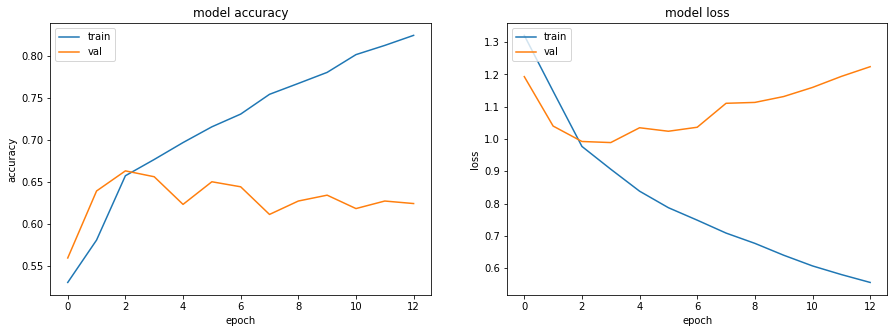

In [36]:
myplot(history5)

## Comparative analysis

[ TO DO STUDENTS]

Present a comparative report of the results you obtained and comment those results

the list of confusion matrixes of previous models


32/32 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           1       0.49      0.59      0.54       159
           2       0.20      0.06      0.09        51
           3       0.11      0.06      0.07        71
           4       0.24      0.07      0.11       163
           5       0.68      0.86      0.76       556

    accuracy                           0.59      1000
   macro avg       0.34      0.33      0.31      1000
weighted avg       0.51      0.59      0.54      1000



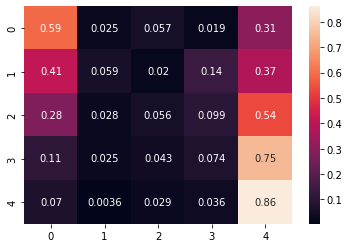

In [37]:
evaluate_the_model(model1, X_test_enc2, y_test)

32/32 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           1       0.54      0.67      0.60       159
           2       0.36      0.10      0.15        51
           3       0.00      0.00      0.00        71
           4       0.30      0.17      0.21       163
           5       0.71      0.90      0.79       556

    accuracy                           0.64      1000
   macro avg       0.38      0.37      0.35      1000
weighted avg       0.55      0.64      0.58      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


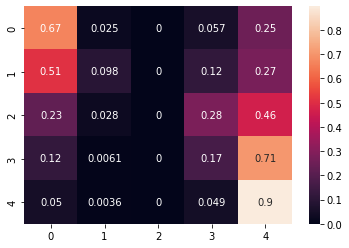

In [38]:
evaluate_the_model(model2, X_test_enc2, y_test)

32/32 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

           1       0.49      0.72      0.58       159
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        71
           4       0.42      0.03      0.06       163
           5       0.69      0.94      0.80       556

    accuracy                           0.64      1000
   macro avg       0.32      0.34      0.29      1000
weighted avg       0.53      0.64      0.55      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


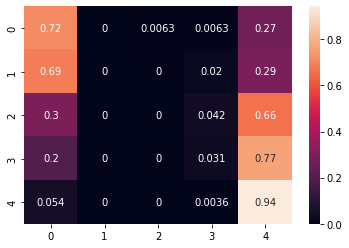

In [39]:
evaluate_the_model(model3, X_test_enc2, y_test)

32/32 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           1       0.48      0.67      0.56       159
           2       0.00      0.00      0.00        51
           3       0.10      0.01      0.02        71
           4       0.32      0.07      0.11       163
           5       0.71      0.93      0.80       556

    accuracy                           0.64      1000
   macro avg       0.32      0.34      0.30      1000
weighted avg       0.53      0.64      0.56      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


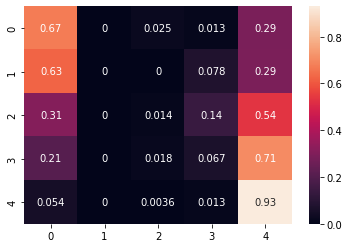

In [40]:
evaluate_the_model(model4, X_test_enc2, y_test)

32/32 [==============================] - 2s 12ms/step
              precision    recall  f1-score   support

           1       0.49      0.74      0.59       159
           2       0.00      0.00      0.00        51
           3       0.00      0.00      0.00        71
           4       0.00      0.00      0.00       163
           5       0.69      0.94      0.79       556

    accuracy                           0.64      1000
   macro avg       0.24      0.34      0.28      1000
weighted avg       0.46      0.64      0.54      1000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


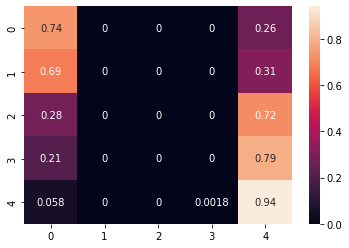

In [41]:
evaluate_the_model(model5, X_test_enc2, y_test)

# Your code here

___

In all five models, we deduce from the learning curves that all the models over-fit. From the confusion matrixes, we see that the model are quite good in classifying reviews having 1 or 5 stars, this derives from the accuracy metric given to the models.

Since models overfit we should try to decoplexify them by introducing batches or by using the residual strategy.

# [BONUS] Improving our baseline

You can now explore ways to improve your model, either by reducing overfitting, exploring the best hyperparameters, tackle the issue of class imbalance...

Any try at improving the model will be greatly appreciated.

In [42]:
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


In [43]:
# Your code here
embedding_size=50
model6=Sequential()
model6.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))

nb_classes = 5

model6.add(GRU(4))
# model6.add(Dense(4, activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(nb_classes, activation='softmax'))

print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 50)           654950    
                                                                 
 gru_1 (GRU)                 (None, 4)                 672       
                                                                 
 dropout (Dropout)           (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 5)                 25        
                                                                 
Total params: 655,647
Trainable params: 655,647
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
model6.compile(loss="categorical_crossentropy",
                  optimizer='adam', metrics=['accuracy'])

In [45]:
batch_size = 32
num_epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.0005, patience=10, restore_best_weights=True, verbose=1)
# fit model
history6 = model6.fit(
    X_train_enc2, y_train_encoded, 
    validation_data=(X_val_enc2, y_val_encoded), 
    batch_size=batch_size,callbacks=[es], 
    epochs=num_epochs)

Epoch 1/100
157/157 [==============================] - 4s 13ms/step - loss: 1.4674 - accuracy: 0.5176 - val_loss: 1.2683 - val_accuracy: 0.5620
Epoch 2/100
157/157 [==============================] - 2s 10ms/step - loss: 1.2124 - accuracy: 0.5714 - val_loss: 1.1376 - val_accuracy: 0.6090
Epoch 3/100
157/157 [==============================] - 2s 10ms/step - loss: 1.0964 - accuracy: 0.6278 - val_loss: 1.0799 - val_accuracy: 0.6280
Epoch 4/100
157/157 [==============================] - 2s 10ms/step - loss: 1.0182 - accuracy: 0.6514 - val_loss: 1.0486 - val_accuracy: 0.6410
Epoch 5/100
157/157 [==============================] - 2s 10ms/step - loss: 0.9444 - accuracy: 0.6736 - val_loss: 1.0344 - val_accuracy: 0.6440
Epoch 6/100
157/157 [==============================] - 2s 10ms/step - loss: 0.8945 - accuracy: 0.6854 - val_loss: 1.0322 - val_accuracy: 0.6490
Epoch 7/100
157/157 [==============================] - 2s 10ms/step - loss: 0.8546 - accuracy: 0.6992 - val_loss: 1.0375 - val_accuracy:

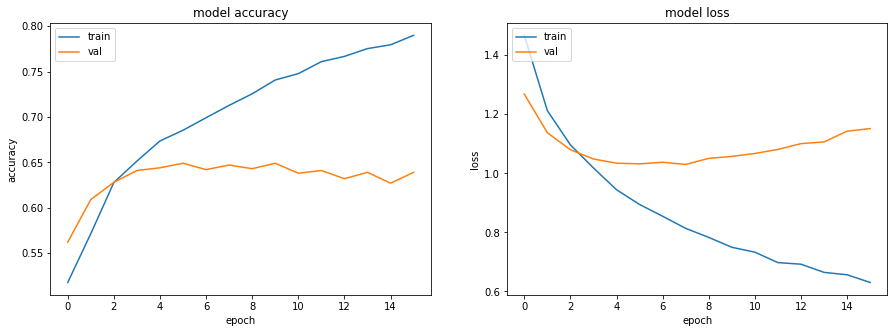

In [46]:
myplot(history6)

32/32 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           1       0.46      0.65      0.54       159
           2       0.00      0.00      0.00        51
           3       1.00      0.01      0.03        71
           4       0.14      0.01      0.01       163
           5       0.67      0.92      0.77       556

    accuracy                           0.62      1000
   macro avg       0.45      0.32      0.27      1000
weighted avg       0.54      0.62      0.52      1000



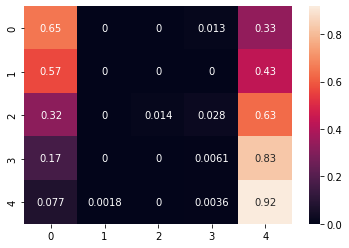

In [47]:
evaluate_the_model(model6, X_test_enc2, y_test)

The model I propose, is still overfitting, but it seems to have better precision. The goal of this section was to reduce overfitting. I have tried a lot of different combinations of RNN, using dropout, regulizers, batchNormalisers, but I have not found out one satisfying my expectation. With this last implementation, I reduce the number of units of the GRU layer, I add dropout and at the end I put a dense layer returning the most likely class among the five possible classes using the softmax activation.